In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
from skimage import io
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose,Input,Dropout, UpSampling2D, concatenate
from tensorflow.keras.applications import VGG19
from keras.optimizers import Adam
from warnings import filterwarnings
filterwarnings('ignore')

import random
from tqdm import tqdm

import glob
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

In [2]:
img_path="D:\\fullimage_224"
mask_path="D:\\imgpreROI"
test_img="D:\\Calc\\Test_FULL"
test_mask="D:\\Calc\\Test_MASK"
train_img="D:\\Calc\\Train_FULL"
train_mask="D:\\Calc\\Train_MASK"
data_csv_path="D:\\roi_calc.csv"
train_images = []
train_masks=[]
img_size = (224, 224)
num_classes = 4
batch_size = 32

In [3]:
def unet(pretrained_weights=None, input_size=(512 , 512, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)     # 将部分隐藏层神经元丢弃，防止过于细化而引起的过拟合情况
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)  # axis=1代表列合并, axis=2代表行合并，axis=3代表层合并
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

    print(inputs.shape, conv10.shape)
    model = Model(inputs, conv10)

    model.compile(optimizer=Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

    # model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [4]:
def load_train(width, height, batch_size):
    fx = 0.0
    fy = 0.0
    # 处理列表得到数组
    images_path = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".png")
    ]
)
    labels_path= sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") 
    ]
)
    # 进入循环读取照片
    while True:
        # 下面定义两个数组来装每个批次(batch_size)的数据
        image_data_array = []
        label_data_array = []
        # 随机选一组数据
        index_group = np.random.randint(0, len(images_path), batch_size)
        # print("batch_size:", str(index_group))
        for index in index_group:
            image = images_path[index]
            label = labels_path[index]

            image_data = cv2.imread(image)
            # 这里需要resize一下图片的长宽，让长宽与模型接收的长宽一致
            image_data = cv2.resize(image_data, (width, height), fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
            image_data = image_data.astype(np.float32)
            image_data = np.multiply(image_data, 1.0 / 255.0)
            image_data_array.append(image_data)

            label_data = cv2.imread(label)
            # label_data = cv2.cvtColor(label_data, cv2.COLOR_GRAY2BGR) # 颜色转化
            label_data = cv2.resize(label_data, (width, height), fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
            label_data = label_data.astype(np.float32)
            label_data = np.multiply(label_data, 1.0 / 255.0)
            label_data_array.append(label_data)

        image_data_r = np.array(image_data_array)
        label_data_r = np.array(label_data_array)

        yield image_data_r, label_data_r

In [5]:
def load_test(width, height, batch_size):
    fx = 0.0
    fy = 0.0
    # 处理列表得到数组
    images_path = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".png")
    ]
)
    labels_path= sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") 
    ]
)
    # 进入循环读取照片

    # for image, label in zip(images_path, labels_path):
    image_data_array = []
    label_data_array = []
    index_group = np.random.randint(0, len(images_path), batch_size)
    # print("batch_size:", str(index_group))
    for index in index_group:
        image = images_path[index]
        label = labels_path[index]

        image_data = cv2.imread(image)
        image_data = cv2.resize(image_data, (width, height), fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
        image_data = image_data.astype(np.float32)
        image_data = np.multiply(image_data, 1.0 / 255.0)
        image_data_array.append(image_data)

        label_data = cv2.imread(label)
        # label_data = cv2.cvtColor(label_data, cv2.COLOR_GRAY2BGR) # 颜色转化
        label_data = cv2.resize(label_data, (width, height), fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
        label_data = label_data.astype(np.float32)
        label_data = np.multiply(label_data, 1.0 / 255.0)
        label_data_array.append(label_data)

    image_data_r = np.array(image_data_array)
    label_data_r = np.array(label_data_array)

    return image_data_r, label_data_r


(None, 512, 512, 3) (None, 512, 512, 3)
Epoch 1/25
20/20 [==============================] - 18s 853ms/step - loss: 0.8824 - accuracy: 0.7639 - val_loss: 0.8604 - val_accuracy: 0.7535
Epoch 2/25
20/20 [==============================] - 17s 847ms/step - loss: 0.8209 - accuracy: 0.7208 - val_loss: 0.8004 - val_accuracy: 0.7097
Epoch 3/25
20/20 [==============================] - 17s 861ms/step - loss: 0.7867 - accuracy: 0.6741 - val_loss: 0.7720 - val_accuracy: 0.6753
Epoch 4/25
20/20 [==============================] - 17s 869ms/step - loss: 0.7477 - accuracy: 0.5776 - val_loss: 0.7439 - val_accuracy: 0.5702
Epoch 5/25
20/20 [==============================] - 17s 854ms/step - loss: 0.7233 - accuracy: 0.2012 - val_loss: 0.7194 - val_accuracy: 0.1352
Epoch 6/25
20/20 [==============================] - 17s 855ms/step - loss: 0.7034 - accuracy: 0.0589 - val_loss: 0.6960 - val_accuracy: 0.0465
Epoch 7/25
20/20 [==============================] - 17s 860ms/step - loss: 0.6857 - accuracy: 0.0324 -

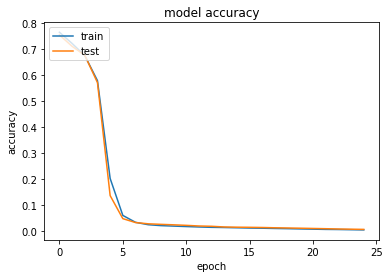

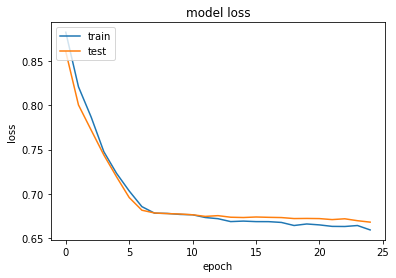

In [9]:
import matplotlib.pyplot as plt
model = unet()
# 这里调用load_train(csvDir, width, height, batch_size)产生数据
# 如果内存小batch_size就设为1吧
history = model.fit_generator(load_train(512, 512, 4), workers=1,
                              steps_per_epoch=20, epochs=25,
                              validation_data=load_test(512, 512, 4)
                              )


model.save('modelWithWeight.h5')
model.save_weights('fine_tune_model_weight')

# print(history.history)

# 展示一下精确度的随训练的变化图
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 展示一下loss随训练的变化图
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [4]:
import random
from tensorflow.python.keras.models import load_model
import numpy as np
import cv2

# # 加载模型h5文件


class ArrayEmpty(Exception):
    def __str__(self):
        return "预测列表为空，请使用Predict.add()往列表添加地址"
class MatteMatting():
    def __init__(self, original_graph, mask_graph, input_type='path'):
        """
        将输入的图片经过蒙版转化为透明图构造函数
        :param original_graph:输入的图片地址、PIL格式、CV2格式
        :param mask_graph:蒙版的图片地址、PIL格式、CV2格式
        :param input_type:输入的类型，有path：图片地址、pil：pil类型、cv2类型
        """
        if input_type == 'path':
            self.img1 = cv2.imread(original_graph)
            self.img2 = cv2.imread(mask_graph)
        elif input_type == 'pil':
            self.img1 = self.__image_to_opencv(original_graph)
            self.img2 = self.__image_to_opencv(mask_graph)
        elif input_type == 'cv2':
            self.img1 = original_graph
            self.img2 = mask_graph
        else:
            raise UnsupportedFormat(input_type)

class Predict():
    def __init__(self, model_path, show_summary=False):
        self.item_list = []
        self.model = load_model(model_path)
        if show_summary:
            self.model.summary()

    def add(self, path):
        """
        :param path: 预测图片列表地址
        """
        self.item_list.append(path)

    def predict_all(self, model_in_size, original_size):
        """
        预测一组数据,并返回值
        :param model_out_size: 模型的输入尺寸(width,height)
        :param original_size: 图片原始尺寸。程序会自动将尺寸还原为这个尺寸(width,height)
        :return:迭代器返回生成结果
        """
        if len(self.item_list):
            for item in self.item_list:
                dc = self.predict_one(item, model_in_size, original_size)
                yield dc
        else:
            raise ArrayEmpty()

    def predict_one(self, path, model_in_size, original_size):
        """
        预测一个数据,并返回值
        :param path: 需要预测的数据
        :param model_out_size: 模型的输入尺寸(width,height)
        :param original_size: 图片原始尺寸。程序会自动将尺寸还原为这个尺寸(width,height)
        :return:
        """
        src = [path]
        get = self.__read_file(model_in_size, src=src)
        predict = self.model.predict(get)
        ii = 0
        dc = cv2.resize(predict[ii, :, :, :], original_size)  # 后面这个参数是形状恢复为原来的形状
        return dc

    @staticmethod
    def __read_file(size_tuple, src=[]):
        """
        规范化图片大小和像素值
        :param size_tuple: 图片大小，要求为元组(width,height)
        :param src:连接列表
        :return:返回预测图片列表
        """
        pre_x = []
        for s in src:
            print(s)
            input = cv2.imread(s)
            input = cv2.resize(input, size_tuple)
            input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
            pre_x.append(input)  # input一张图片
        pre_x = np.array(pre_x) / 255.0
        return pre_x


In [ ]:
if __name__ == '__main__':
    import os
    
    data_path_array = []
    # 需要预测的图片的文件夹
    resDir = 'D:\\Calc\\Train_FULL\\Calc-Training_P_00005_RIGHT_CC.png'
    # 将需要预测的图片地址存入数组
    data_path_array.append(os.path.join(root, file))
    print(data_path_array)
	# 这里使用我整理的那个类，实例化的时候先把训练得到的模型权重文件放进去
    pd = Predict("h5/modelWithWeight.h5")
    # 然后调用我整理的那个类类里面的add方法把需要预测的地址添加进去
    for item in data_path_array:
        pd.add(item)
    # 调用里面的predict_all方法，返回的是一个生成器，需要我们用next来读取
    dd = pd.predict_all((512, 512), (1918, 1280))
    # 保存到指定位置
    for item in data_path_array:
        dc = next(dd)
        dc = (dc * 255).astype(np.uint8)  # 把dtype从float32转化为uint8
        item = cv2.imread(item)
        # dc.dtype='uint8'
        mm = MatteMatting(item, dc, input_type='cv2')
        mm.save_image(r"E:\train_data\carChallenge\data_out\{}.png".format(str(random.randint(1, 10000000))), mask_flip=True)
        



In [ ]:
input_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".png")
    ]+[
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".png")
    ]
)

# 取得目標圖遮罩的檔案路徑
target_img_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") 
    ]+[
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") 
    ]
)

print("樣本數:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

In [ ]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# 設定檢查點 callbacks，模型存檔
# callbacks = [
#     keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
# ]

# 訓練 15 週期(epoch)
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

In [ ]:
#視覺化
train_input_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".png")
    ]
)
print(train_input_img_paths)

# 取得目標圖遮罩的檔案路徑
train_target_img_paths= sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") 
    ]
)
def pict(mask,img):
    for a,i in enumerate(mask):
        for b,j in enumerate(i):
            for c,k in enumerate(j):
                if k==255 and c!=2:
                    img[a][b][c]=0
                elif k==255 and c==2:
                    img[a][b][c]=255
    return img
                    
count=0
fig,axs=plt.subplots(12,3,figsize=(200,500))
for img_path in os.listdir(test_img):
    img=cv2.imread(test_img+"\\{}".format(img_path))
    axs[count][0].title.set_text(img_path)
    axs[count][0].imshow(img)
    mask=cv2.imread(test_mask+"\\{}".format(img_path))
    axs[count][1].title.set_text(img_path)
    axs[count][1].imshow(mask, cmap='gray')
    img=pict(mask,img)                
    axs[count][2].title.set_text("mammogram with Mask")
    axs[count][2].imshow(img)
    count +=1
    if (count==12):
        break    
fig.tight_layout()

In [17]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
test_img="D:\\Calc\\Test_FULL"
test_mask="D:\\Calc\\Test_MASK"
train_img="D:\\Calc\\Train_FULL"
train_mask="D:\\Calc\\Train_MASK"
seed = 42
random.seed = seed
np.random.seed = seed
train_input_img= sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".png")
    ]
)
train_input_mask= sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png")
    ]
)
test_input_img= sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".png")
    ]
)
test_input_mask= sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png")
    ]
)
print(test_input_img_paths)

['D:\\Calc\\Test_FULL\\Calc-Test_P_00038_LEFT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00038_LEFT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00038_RIGHT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00038_RIGHT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00041_LEFT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00041_LEFT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00077_LEFT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00077_LEFT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00077_RIGHT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00077_RIGHT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00100_RIGHT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00100_RIGHT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00127_RIGHT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00127_RIGHT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00132_LEFT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00140_LEFT_CC.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00140_LEFT_MLO.png', 'D:\\Calc\\Test_FULL\\Calc-Test_P_00140_RIGHT_CC.png', 'D:\\Calc

In [26]:
def data_generator(train_img,train_mask,test_img):
    # Get and resize train images and masks
    X_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_img), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, path in tqdm(enumerate(train_img), total=len(train_img)):
        img =cv2.imread(path)[:,:,:IMG_CHANNELS]
        img =cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # resize成128*128
        X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for n, path in tqdm(enumerate(train_mask), total=len(train_mask)):
        mask_ = cv2.imread(path)
        mask_=cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
#         mask_ = np.expand_dims(mask_, axis=-1)
#         mask = np.maximum(mask, mask_)
        Y_train[n] = mask

    # Get and resize test images
    X_test = np.zeros((len(test_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n,path in tqdm(enumerate(test_img), total=len(test_img)):
        img = cv2.imread(path)[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        X_test[n] = img

    print('Data Generate Done!')
    return X_train,Y_train,X_test,sizes_test

X_train,Y_train,X_test,sizes_test = data_generator(train_input_img,train_input_mask,test_input_img)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(sizes_test.shape)

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:00<00:00, 1591.88it/s]

Getting and resizing test images ... 



100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 1832.24it/s]


Data Generate Done!
(1226, 512, 512, 3)
(1226, 512, 512, 1)
(284, 512, 512, 3)


AttributeError: 'list' object has no attribute 'shape'

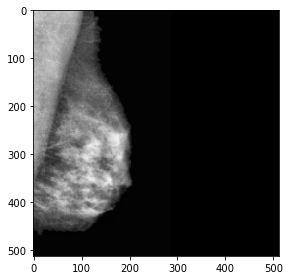

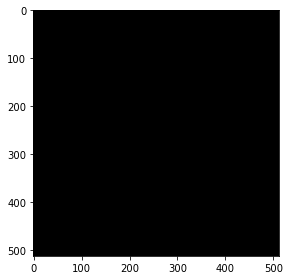

In [27]:
# 查看数据是否正确
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [32]:
def UNetModel(pretrained_weights=None, input_size=(512 , 512, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)     # 将部分隐藏层神经元丢弃，防止过于细化而引起的过拟合情况
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)  # axis=1代表列合并, axis=2代表行合并，axis=3代表层合并
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

    print(inputs.shape, conv10.shape)
    model = Model(inputs, conv10)

    model.compile(optimizer=Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

    # model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
model = UNetModel()

(None, 512, 512, 3) (None, 512, 512, 3)


In [40]:
model.fit(x=X_train,y=Y_train, validation_split=0.1,epochs=30,batch_size= 8)

Epoch 1/30


ValueError: in user code:

    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\engine\training.py", line 949, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\Nicol\anaconda3\envs\project\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 512, 512, 3) vs (None, 512, 512, 1)).
